In [283]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import MSTL,AutoARIMA, SeasonalNaive, TBATS,OptimizedTheta,SeasonalExponentialSmoothingOptimized
import seaborn as sns
from hmmlearn import hmm
from datasetsforecast.losses import (
    mae, mape, mase, rmse, smape
)
import warnings 
warnings.filterwarnings('ignore') 

[StatsForecast](https://nixtlaverse.nixtla.io/statsforecast/index.html)

In [284]:
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,10)

This data contains 5 years of daily time series data for several measures of traffic on a statistical forecasting teaching notes website whose alias is statforecasting.com.

In [285]:
path="daily-website-visitors.csv"
df = pd.read_csv(path)

In [286]:
df.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [287]:
df.shape

(2167, 8)

In [288]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Row                2167 non-null   int64 
 1   Day                2167 non-null   object
 2   Day.Of.Week        2167 non-null   int64 
 3   Date               2167 non-null   object
 4   Page.Loads         2167 non-null   object
 5   Unique.Visits      2167 non-null   object
 6   First.Time.Visits  2167 non-null   object
 7   Returning.Visits   2167 non-null   object
dtypes: int64(2), object(6)
memory usage: 135.6+ KB


In [289]:
df.columns = [col.replace(".","_") for col in df.columns]

In [290]:
df["Date"] = pd.to_datetime(df["Date"])
df["Page_Loads"] = df["Page_Loads"].replace(",", "",regex=True).astype("int16")
df["Unique_Visits"] = df["Unique_Visits"].replace(",", "",regex=True).astype("int16")
df["Day_Of_Week"] = df["Day_Of_Week"].astype("int16")
df["First_Time_Visits"] = df["First_Time_Visits"].str.replace(",", "",regex=True).astype("int16")
df["Returning_Visits"] = df["Returning_Visits"].str.replace(",", "",regex=True).astype("int16")
df.drop(columns="Row",inplace=True)

In [291]:
df.describe()

,Day_Of_Week,Date,Page_Loads,Unique_Visits,First_Time_Visits,Returning_Visits
count,2167.000000,2167,2167.000000,2167.000000,2167.000000,2167.000000
mean,3.997231,2017-09-01 00:00:00,4116.989386,2943.646516,2431.824181,511.822335
min,1.000000,2014-09-14 00:00:00,1002.000000,667.000000,522.000000,133.000000
25%,2.000000,2016-03-08 12:00:00,3114.500000,2226.000000,1830.000000,388.500000
50%,4.000000,2017-09-01 00:00:00,4106.000000,2914.000000,2400.000000,509.000000
75%,6.000000,2019-02-24 12:00:00,5020.500000,3667.500000,3038.000000,626.500000
max,7.000000,2020-08-19 00:00:00,7984.000000,5541.000000,4616.000000,1036.000000
std,2.000229,NaN,1350.977843,977.886472,828.704688,168.736370


In [292]:
df.drop(columns="Day",inplace=True)

In [293]:
df.drop(columns="Day_Of_Week",inplace=True)

In [294]:
df.set_index("Date",inplace=True)
df.sort_index(inplace=True)

In [295]:
df_pl = df[["Page_Loads"]]
df_uv = df[["Unique_Visits"]]
df_ftv = df[["First_Time_Visits"]]
df_rv = df[["Returning_Visits"]]

In [296]:
df_pl.head()

,Page_Loads
Date,
2014-09-14,2146
2014-09-15,3621
2014-09-16,3698
2014-09-17,3667
2014-09-18,3316


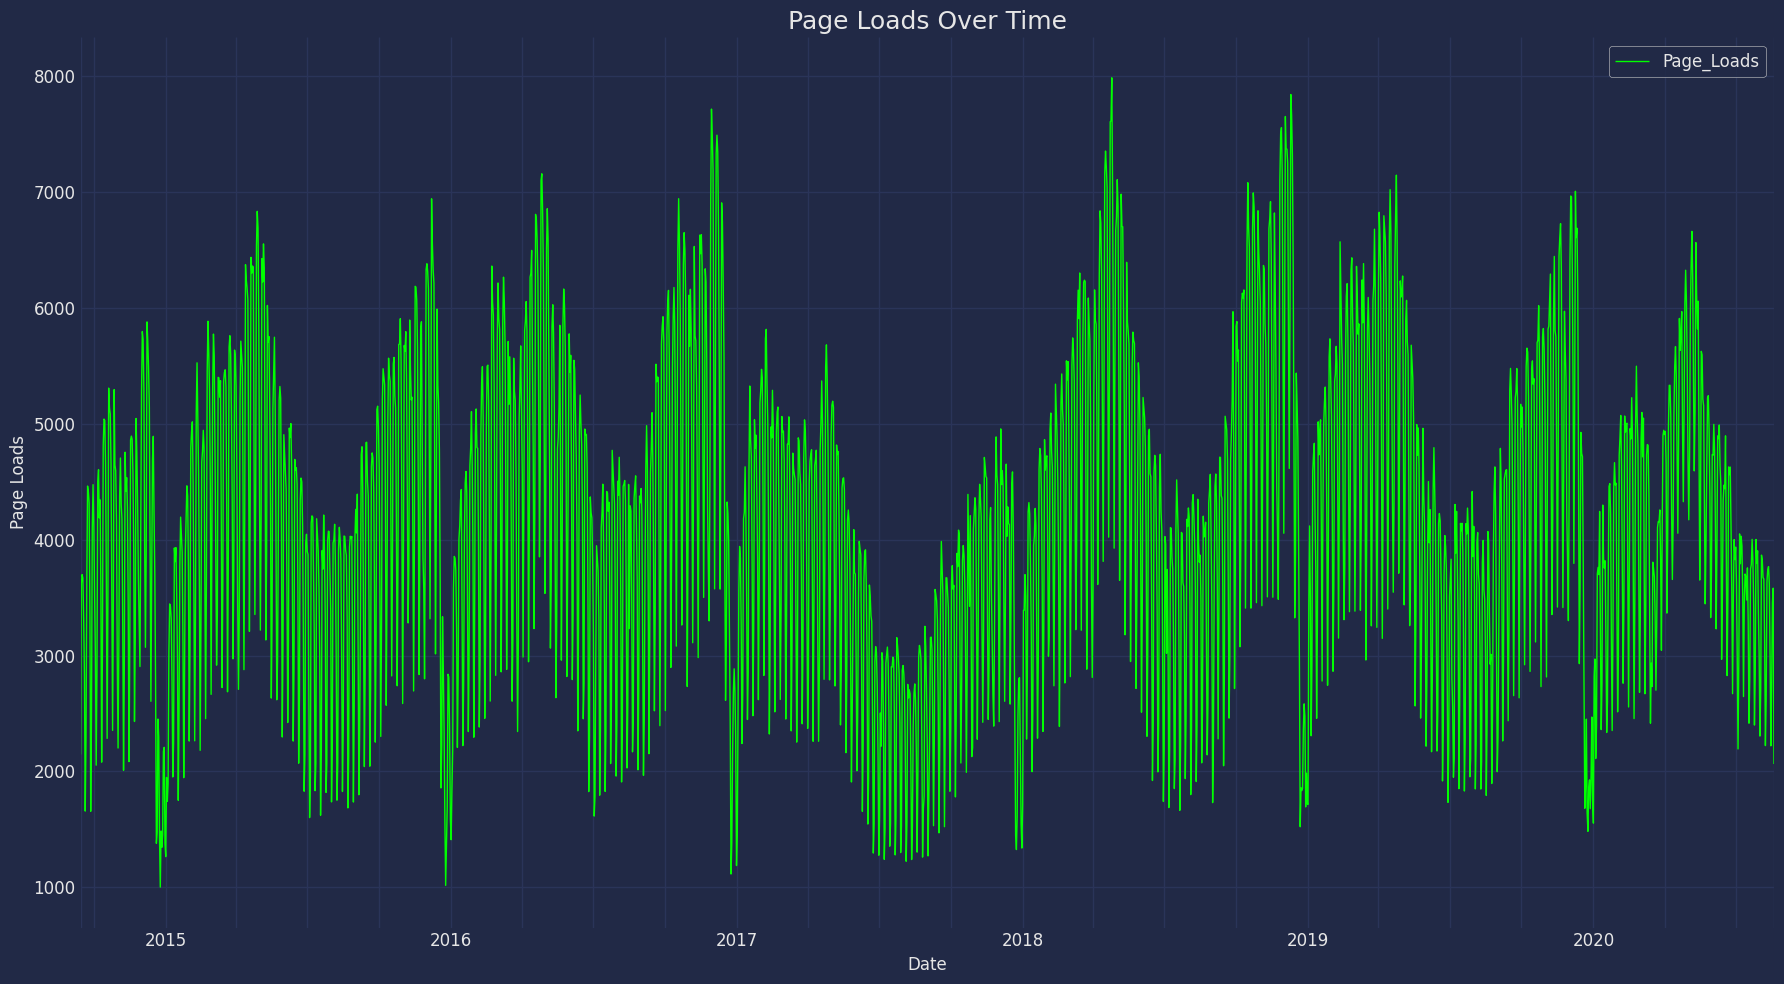

In [297]:
fig, ax = plt.subplots(figsize=(18, 10))
df_pl.plot(ax=ax, color="lime", linestyle="-", linewidth=1, markersize=8)

ax.set_title("Page Loads Over Time", fontsize=18)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Page Loads", fontsize=12)
fig.tight_layout()
plt.show()

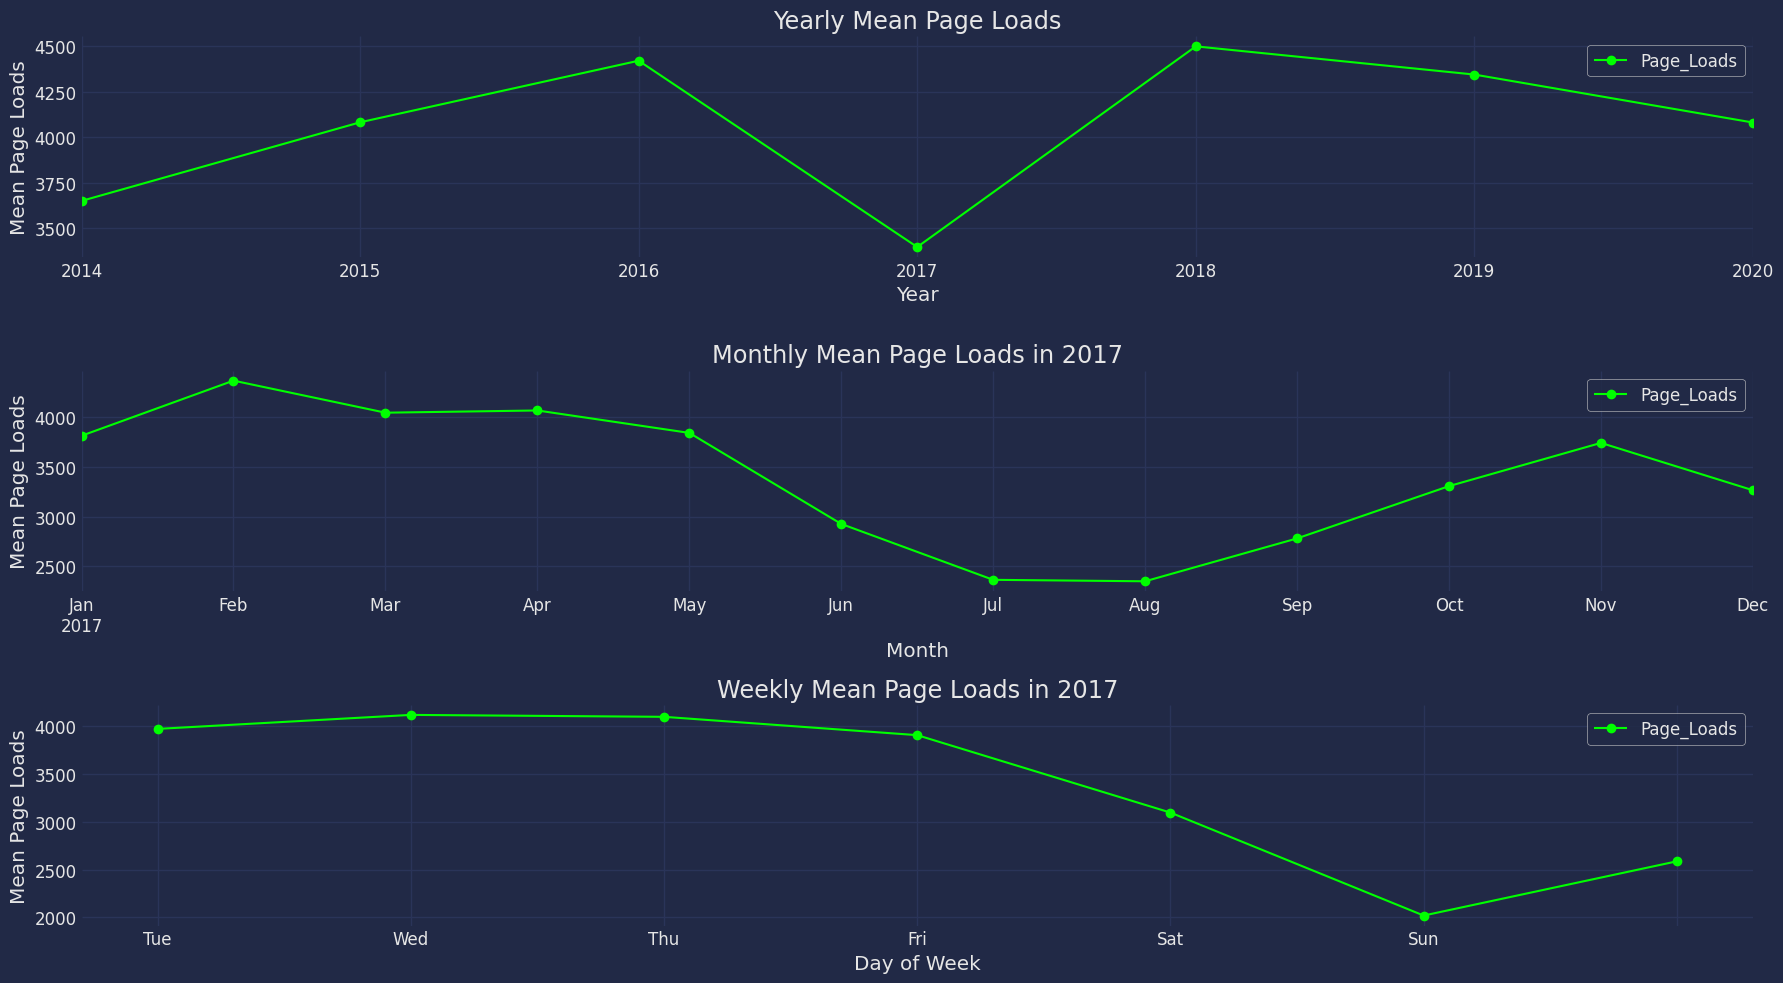

In [298]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 10))

# Annual Average for Total Page Loads
df_pl.resample("A").mean().plot(marker="o", color="lime", ax=axes[0])
axes[0].set_title("Yearly Mean Page Loads")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Mean Page Loads")

# Monthly Average for the year 2017
df_pl["2017-01":"2017-12"].resample("M").mean().plot(marker="o", color="lime", ax=axes[1])
axes[1].set_title("Monthly Mean Page Loads in 2017")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Mean Page Loads")

# Weekly Average for the year 2017
a = df_pl["2017-01":"2017-12"].groupby(df_pl["2017-01":"2017-12"].index.dayofweek).mean()
a.plot(marker="o", color="lime", ax=axes[2])
axes[2].set_title("Weekly Mean Page Loads in 2017")
axes[2].set_xlabel("Day of Week")
axes[2].set_ylabel("Mean Page Loads")
axes[2].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Adjust layout
plt.tight_layout()
plt.show()

#### Forecasting Page Loads

The input to StatsForecast is always a data frame in long format with three columns: *unique_id*, *ds* and *y*:

In [299]:
# Transform dataframe
def transform_dataframe(df, target_column):
    df_transformed = df.reset_index()
    df_transformed.rename(columns={"Date": "ds", target_column: "y"}, inplace=True)
    df_transformed["unique_id"] = "1"
    return df_transformed

df_pl_transformed = transform_dataframe(df_pl, target_column="Page_Loads")

In [300]:
df_pl_transformed.head()

,ds,y,unique_id
0,2014-09-14,2146,1
1,2014-09-15,3621,1
2,2014-09-16,3698,1
3,2014-09-17,3667,1
4,2014-09-18,3316,1


In [301]:
from statsmodels.tsa.stattools import adfuller
# Checking stationary
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")


In [302]:
Augmented_Dickey_Fuller_Test_func(df_pl_transformed["y"],"Ads")

Dickey-Fuller test results for columns: Ads
Test Statistic                   -4.283821
p-value                           0.000474
No Lags Used                     26.000000
Number of observations used    2140.000000
Critical Value (1%)              -3.433409
Critical Value (5%)              -2.862892
Critical Value (10%)             -2.567489
dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary


In [303]:
# Ensure no missing values
df_pl_transformed.dropna(inplace=True)

In [304]:
# Define HMM forecasting model
class HMMForecast:
    def __init__(self, n_components=4):
        self.model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000)
    
    def fit(self, df):
        self.model.fit(df[['y']])
    
    def predict(self, h, df):
        last_value = df['y'].values[-1]
        return pd.DataFrame({
            'unique_id': '1',
            'ds': pd.date_range(start=df['ds'].values[-1], periods=h+1, freq='D')[1:],
            'HMM': [last_value] * h
        })

In [305]:
# Define and fit the models
mstl = MSTL(season_length=[7, 12], trend_forecaster=AutoARIMA())
hmm_model = HMMForecast()
sf = StatsForecast(models=[mstl, SeasonalNaive(season_length=7), TBATS(seasonal_periods=7)], freq="D")
sf = sf.fit(df=df_pl_transformed)
hmm_model.fit(df=df_pl_transformed)

Model is not converging.  Current: -inf is not greater than -19586.803471147334. Delta is -inf


In [306]:
# Plot forecasts
def plot_forecasts(y_hist, y_true, y_pred, models, target_name):
    _, ax = plt.subplots(1, 1, figsize=(20, 7))
    y_true = y_true.merge(y_pred, how="left", on=["unique_id", "ds"])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(30*5)
    df_plot[['y'] + models].plot(ax=ax, linewidth=2)
    
    ax.set_title(f"{target_name} Daily", fontsize=22)
    ax.set_ylabel(f"{target_name}", fontsize=20)
    ax.set_xlabel("Timestamp [t]", fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()

In [307]:
sf = sf.fit(df=df_pl_transformed)

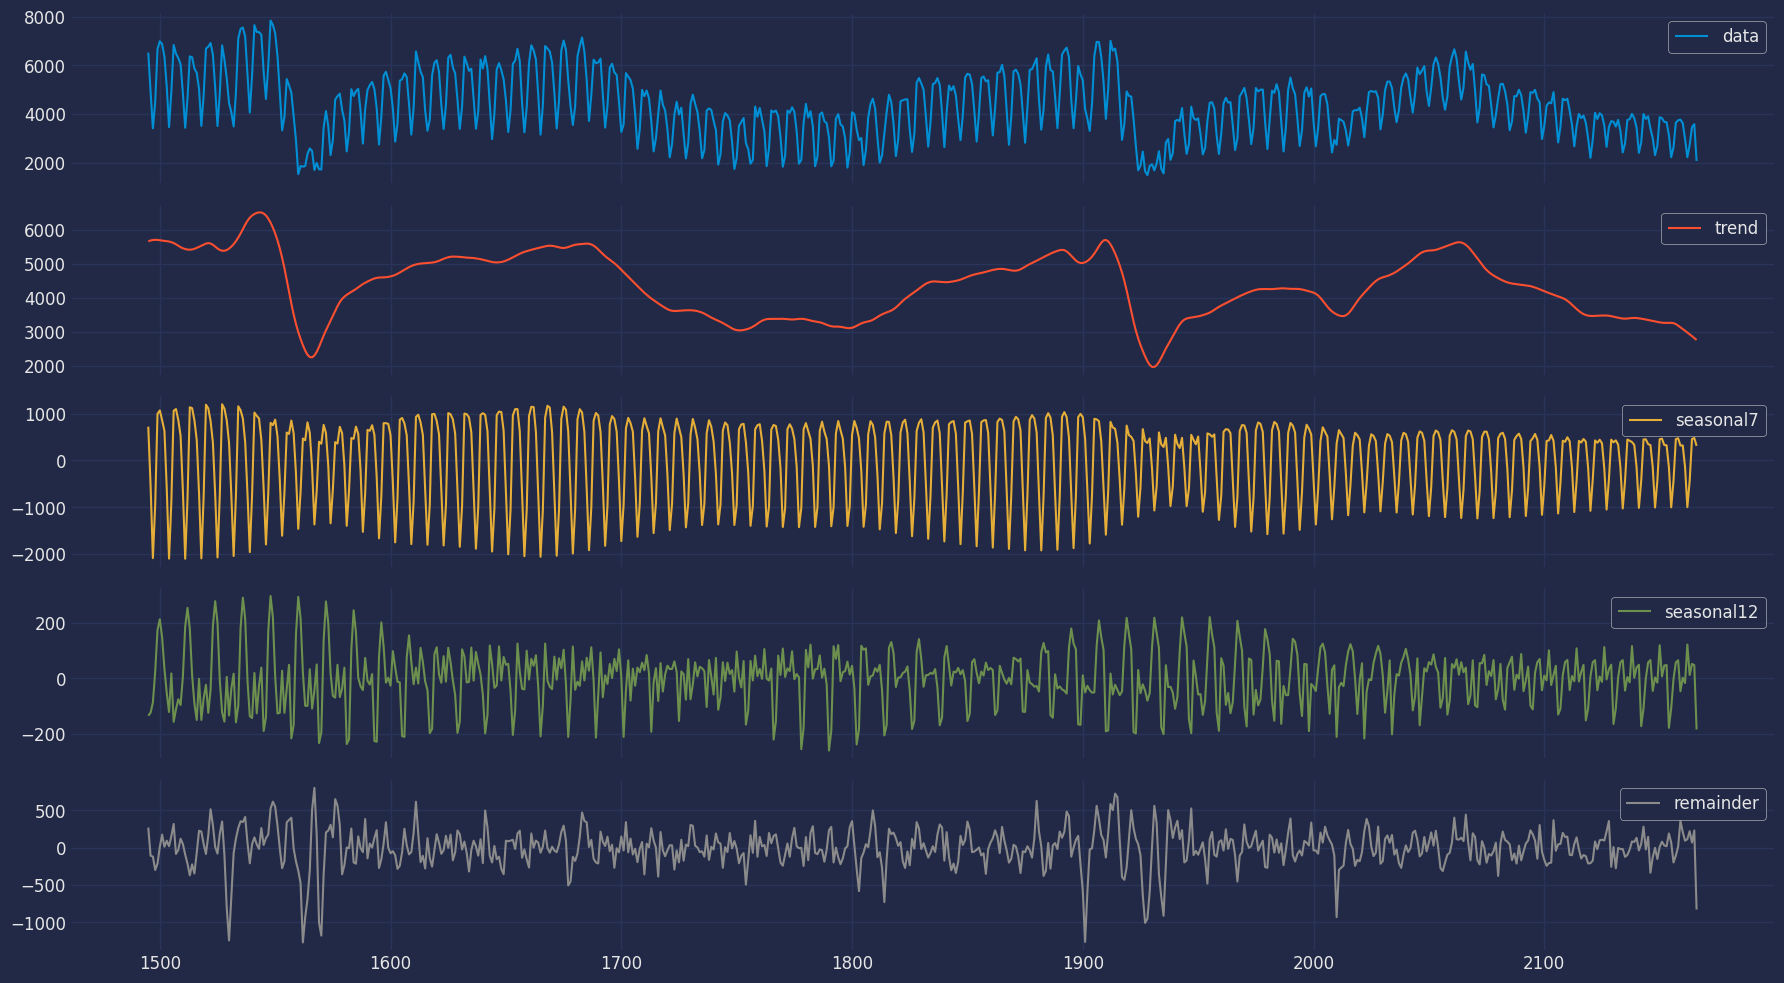

In [308]:
sf.fitted_[0, 0].model_.tail(24 * 28).plot(subplots=True, grid=True,)
plt.tight_layout()
plt.show()

In [309]:
# Split data into training and test sets
df_test = df_pl_transformed.tail(30)
df_train = df_pl_transformed.drop(df_test.index)
season_length = 7

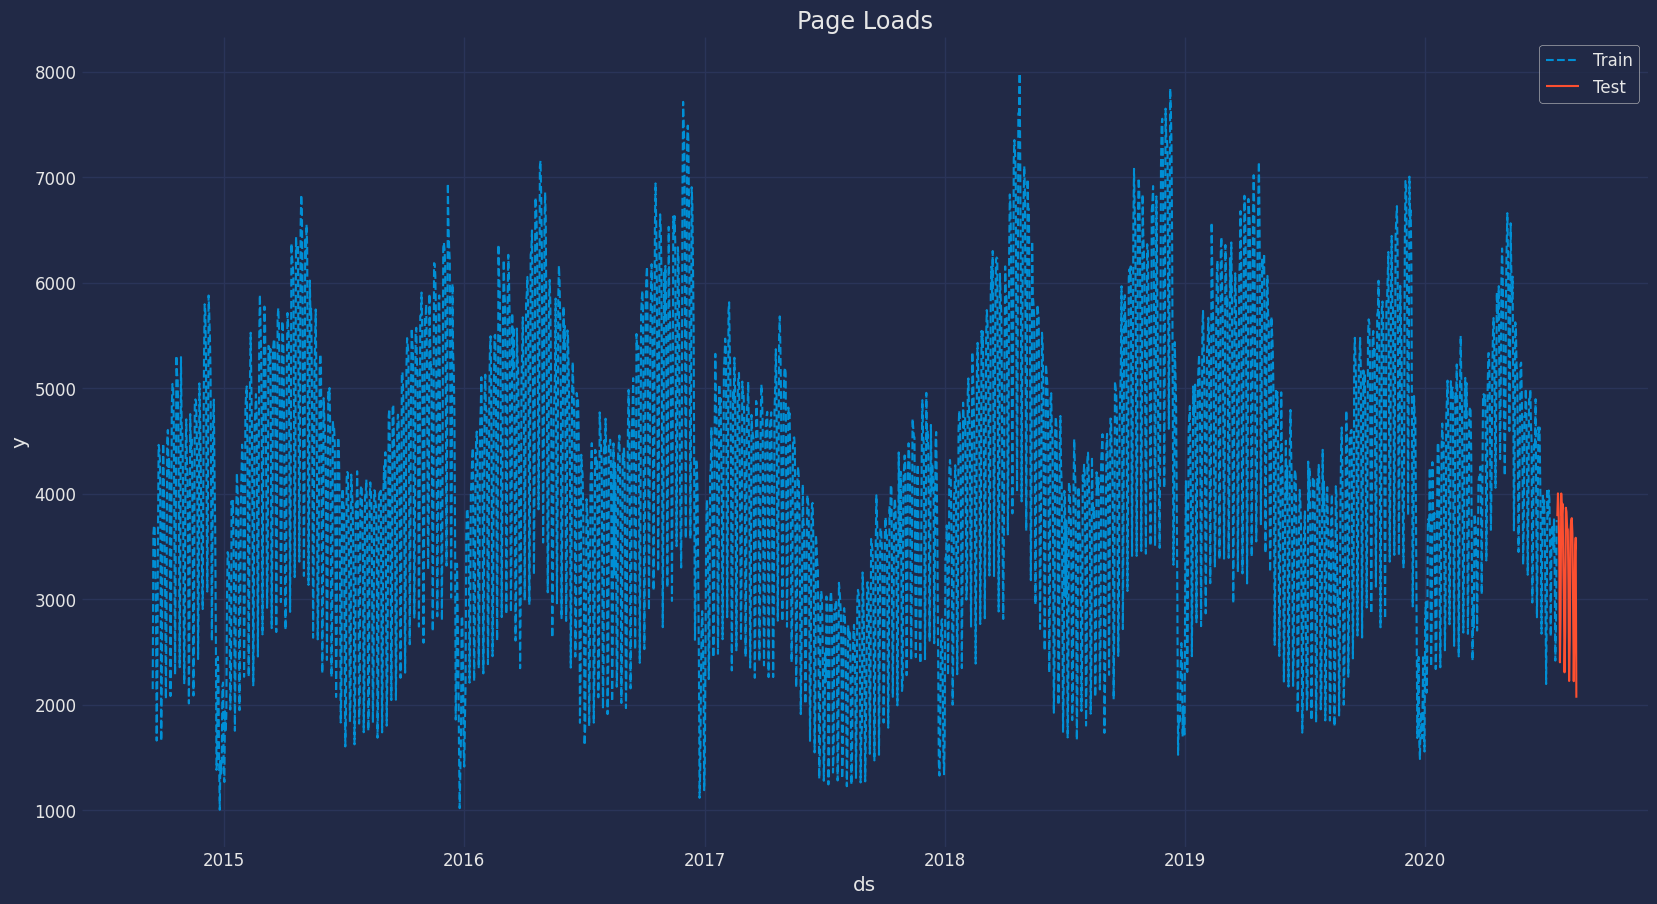

In [310]:
sns.lineplot(df_train,x="ds", y="y", label="Train", linestyle="--")
sns.lineplot(df_test, x="ds", y="y", label="Test")
plt.title("Page Loads");
plt.show()

In [311]:
# Refit the models on the training set
sf = StatsForecast(models=[mstl, SeasonalNaive(season_length=season_length), TBATS(seasonal_periods=season_length)], freq="D")
sf = sf.fit(df=df_train)
hmm_model.fit(df=df_train)


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: -inf is not greater than -19124.53491198792. Delta is -inf


In [312]:
# Make predictions
forecasts_test = sf.predict(h=len(df_test))
hmm_forecasts_test = hmm_model.predict(h=len(df_test), df=df_train)

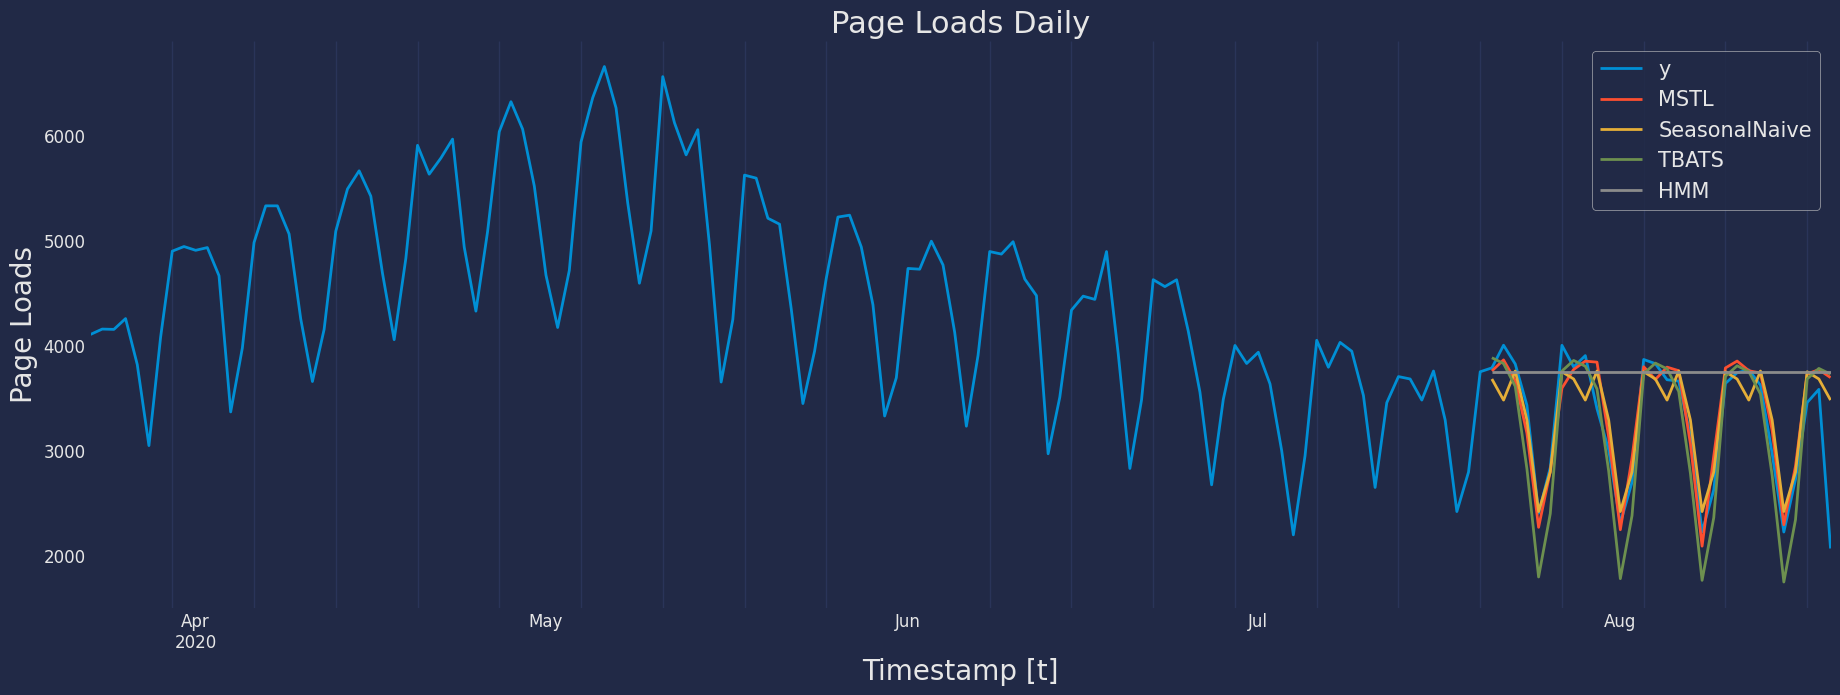

In [313]:
# Combine HMM forecasts with other models' forecasts
forecasts_test = forecasts_test.merge(hmm_forecasts_test, on=["unique_id", "ds"])

plot_forecasts(df_train, df_test, forecasts_test, models=["MSTL", "SeasonalNaive", "TBATS", "HMM"], target_name="Page Loads")


In [314]:
StatsForecast.plot(df_pl_transformed,forecasts_test,engine="plotly")

In [315]:
# Evaluate performance
def evaluate_performance(y_hist, y_true, y_pred, models):
    y_true = y_true.merge(y_pred, how="left", on=["unique_id", "ds"])
    evaluation = {}
    for model in models:
        evaluation[model] = {}
        for metric in [mae, mape, rmse, smape]:
            metric_name = metric.__name__
            evaluation[model][metric_name] = metric(y_true["y"].values, y_true[model].values)
    return pd.DataFrame(evaluation).T

In [329]:
performance = evaluate_performance(df_train, df_test, forecasts_test, models=["MSTL", "SeasonalNaive", "TBATS", "HMM"])
print(performance)


                      mae       mape        rmse      smape
MSTL           198.812271   7.122421  348.106628   6.327327
SeasonalNaive  219.633331   7.504589  333.127441   6.895582
TBATS          286.690247  10.712795  419.687073  10.547685
HMM            545.266667  21.021662   49.176553  17.057263


#### Cross Validation

In [330]:
crossvalidation_df = sf.cross_validation(
    df = df_train,
    h = 30,
    step_size = 24,
    n_windows = 3
  )

In [331]:
crossvalidation_df

,ds,cutoff,y,MSTL,SeasonalNaive,TBATS
unique_id,,,,,,
1,2020-05-04,2020-05-03,5939.0,5672.491699,6038.0,6851.626953
1,2020-05-05,2020-05-03,6361.0,5863.852051,6324.0,7016.845215
1,2020-05-06,2020-05-03,6659.0,5765.279297,6062.0,6943.083008
1,2020-05-07,2020-05-03,6264.0,5747.156250,5520.0,6627.144531
1,2020-05-08,2020-05-03,5359.0,5076.945312,4670.0,5444.730957
...,...,...,...,...,...,...
1,2020-07-16,2020-06-20,3756.0,4675.272461,4895.0,5174.951660
1,2020-07-17,2020-06-20,3289.0,3975.832275,3924.0,4183.175781
1,2020-07-18,2020-06-20,2416.0,3030.394287,2827.0,2834.669189


In [334]:
models = ["MSTL", "SeasonalNaive", "TBATS", ]

metrics_dict = {"model": [], "mae": [], "mape": [], "rmse": [], "smape": []}

for model in models:
    # Calculate metrics
    mae_val = mae(crossvalidation_df["y"], crossvalidation_df[model])
    mape_val = mape(crossvalidation_df["y"], crossvalidation_df[model]) 
    rmse_val = rmse(crossvalidation_df["y"], crossvalidation_df[model])
    smape_val = smape(crossvalidation_df["y"], crossvalidation_df[model])

    # Append values to the dictionary
    metrics_dict["model"].append(model)
    
    metrics_dict["mae"].append(mae_val)
    metrics_dict["mape"].append(mape_val)
    metrics_dict["rmse"].append(rmse_val)
    metrics_dict["smape"].append(smape_val)

metrics_df = pd.DataFrame(metrics_dict).set_index("model")

In [320]:
metrics_df

,mae,mape,rmse,smape
model,,,,
MSTL,537.984131,13.452978,618.774597,12.386517
SeasonalNaive,510.688904,12.611778,610.932129,11.642783
TBATS,829.304077,19.783030,1031.922241,17.387524


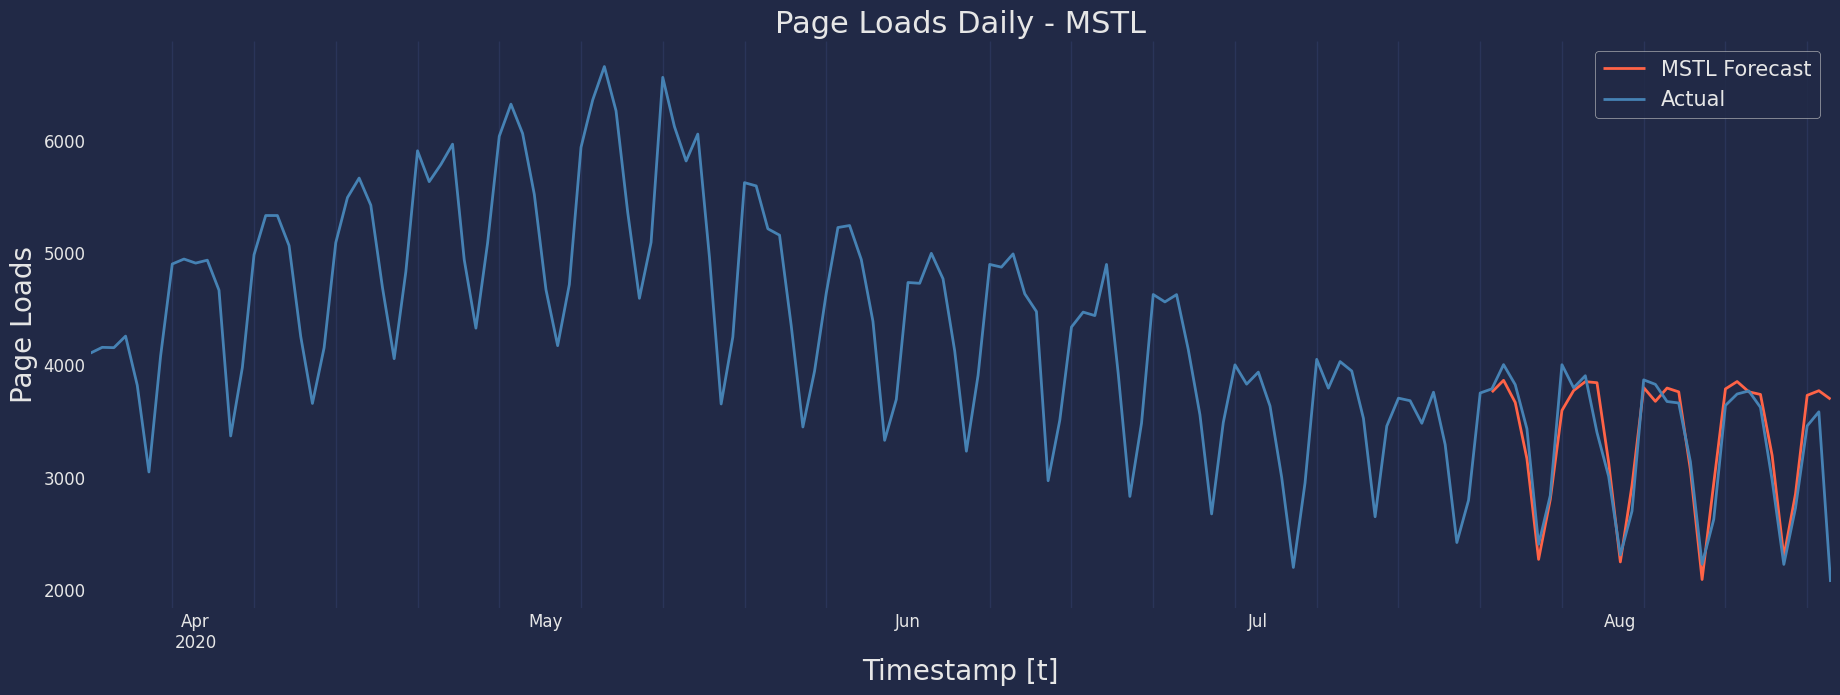

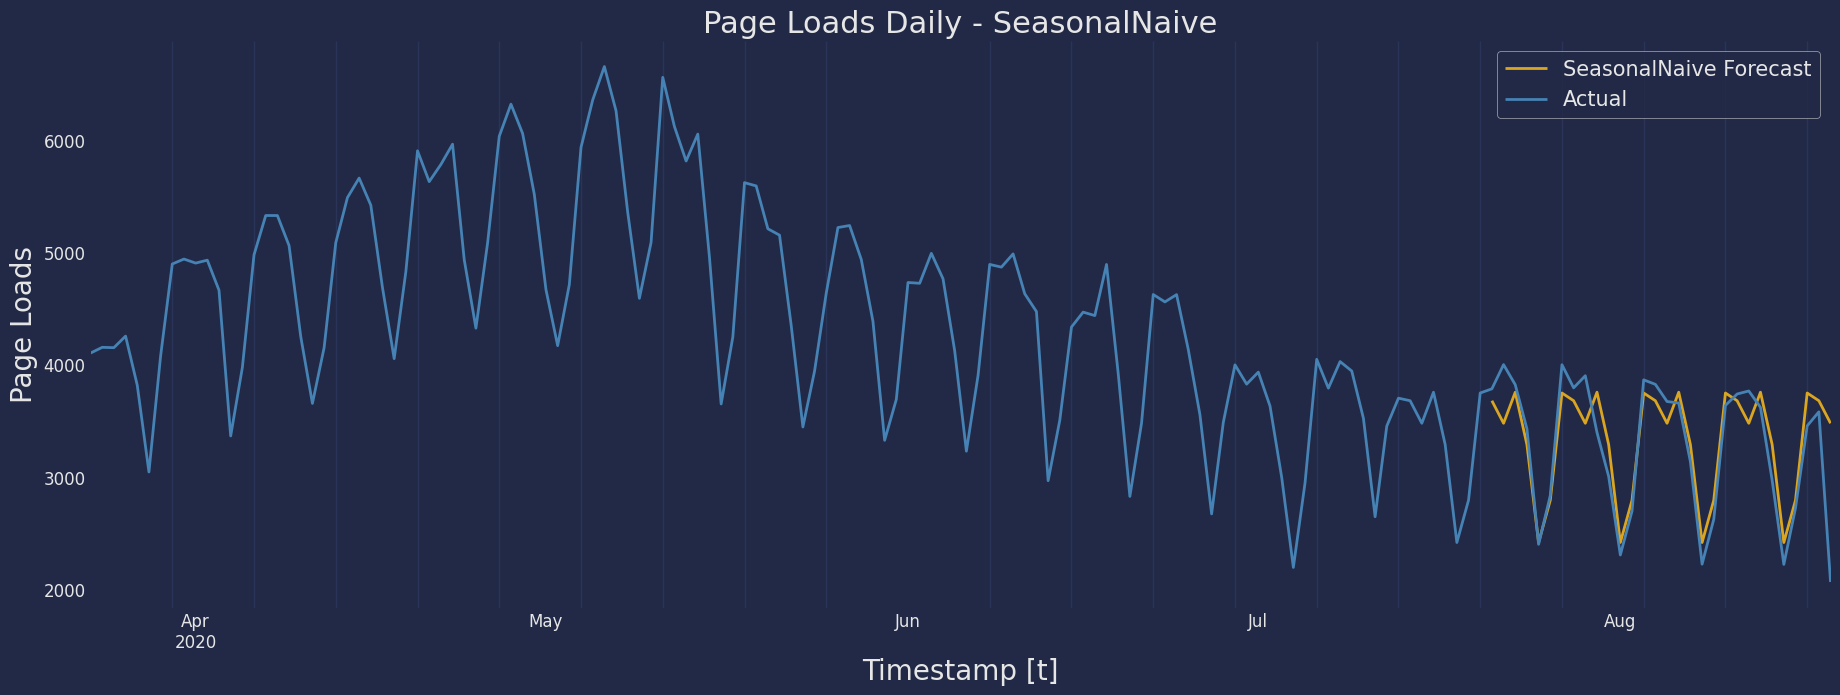

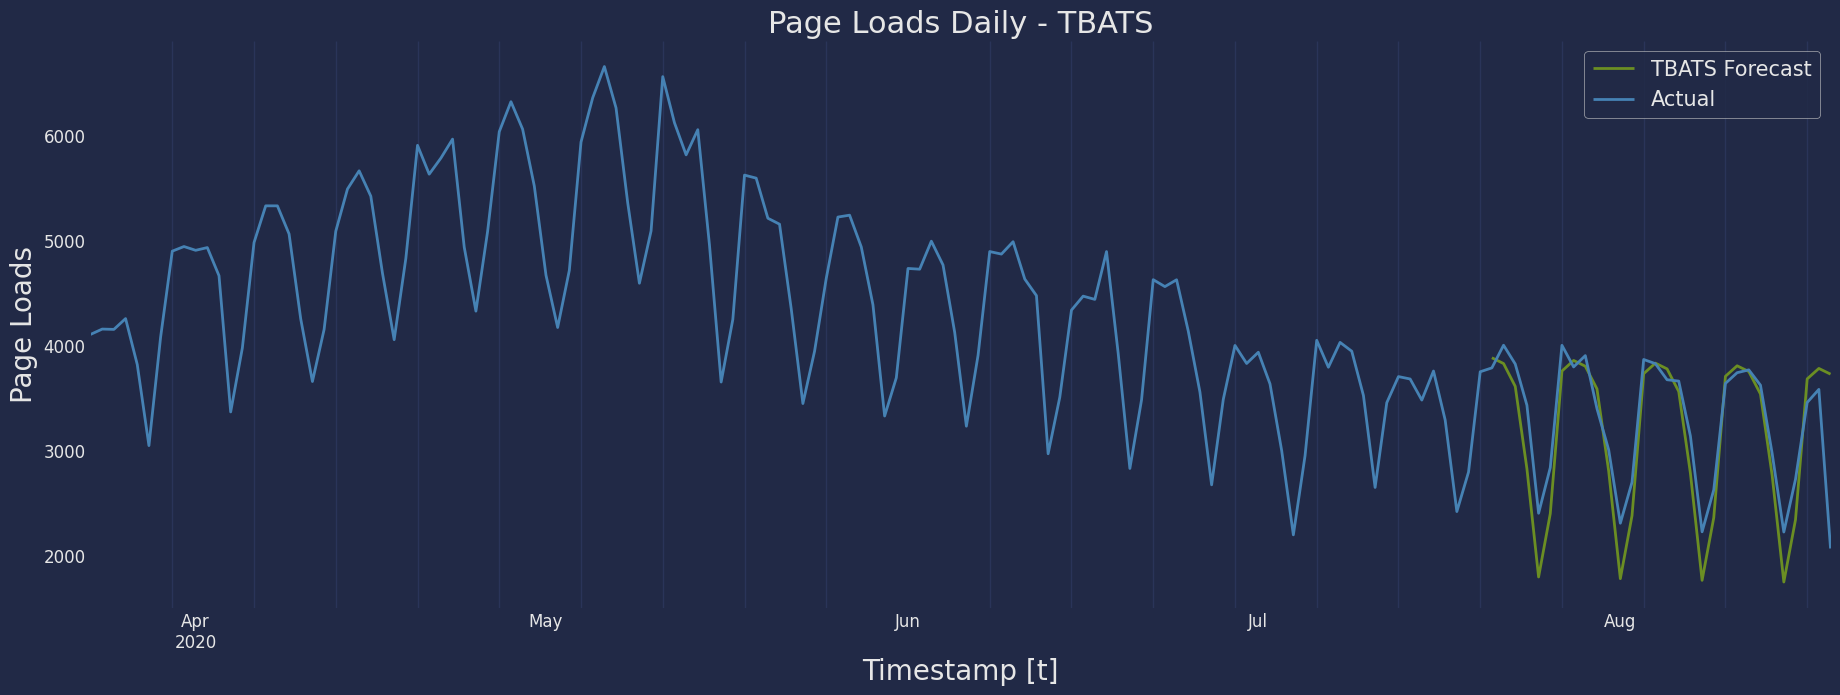

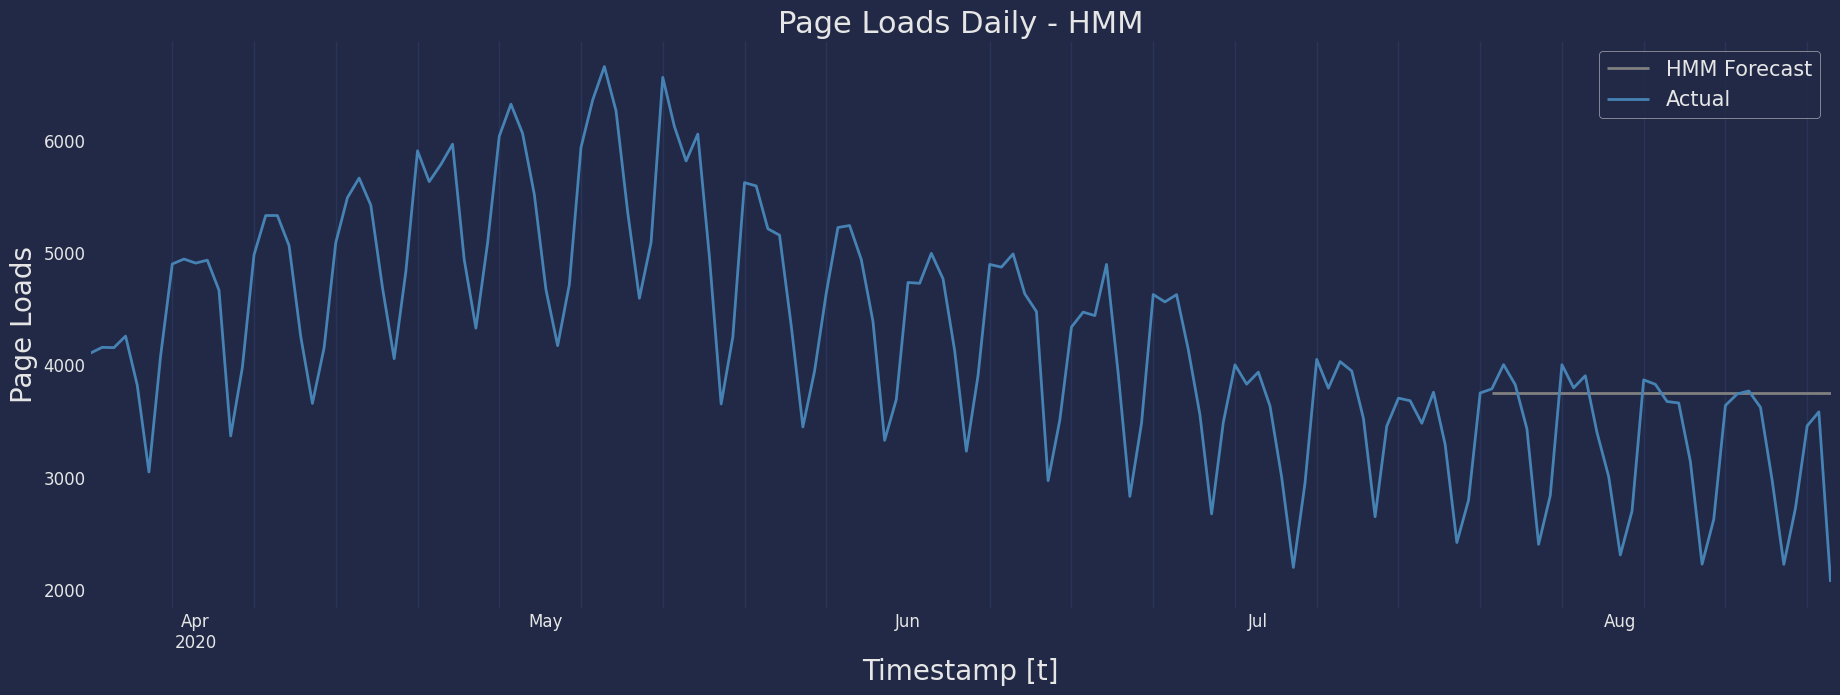

In [326]:
def plot_individual_forecast_with_color(y_hist, y_true, y_pred, model_name, model_color, target_name):
    _, ax = plt.subplots(1, 1, figsize=(20, 7))
    y_true = y_true.merge(y_pred, how="left", on=["unique_id", "ds"])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(30 * 5)
    
    # Lấy màu cho đường dự đoán từ bảng màu
    forecast_color = model_color[model_name]
    
    # Vẽ đường dự đoán với màu tương ứng
    df_plot[model_name].plot(ax=ax, color=forecast_color, linewidth=2, label=model_name + ' Forecast')
    
    # Vẽ đường y
    df_plot['y'].plot(ax=ax, color='steelblue', linewidth=2, label='Actual')
    
    ax.set_title(f"{target_name} Daily - {model_name}", fontsize=22)
    ax.set_ylabel(f"{target_name}", fontsize=20)
    ax.set_xlabel("Timestamp [t]", fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()

# Bảng màu cho các mô hình
model_color = {
    "MSTL": "tomato",
    "SeasonalNaive": "goldenrod",
    "TBATS": "olivedrab",
    "HMM": "grey",
}

# Vẽ biểu đồ dự đoán cho từng mô hình
for model_name in ["MSTL", "SeasonalNaive", "TBATS", "HMM"]:
    plot_individual_forecast_with_color(df_train, df_test, forecasts_test, model_name, model_color, target_name="Page Loads")
    plt.show()